In [1]:
import torch
import os, sys
sys.path.insert(0, '../src')
import wandb
import pickle as pkl
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from data_generator import SpatialDataset, train_val_test_split
from models import LinearSCI, NonlinearSCI
from trainers import Trainer

# Experimental tracking
wandb.login()

np.random.seed(2023)
torch.manual_seed(2023)
torch.cuda.manual_seed(2023)
torch.cuda.manual_seed_all(2023)
torch.backends.cudnn.deterministic = True

wandb: Currently logged in as: ziyang-jiang (carlsonlab). Use `wandb login --relogin` to force relogin


# Load data

In [2]:
with open('../data/synthetic_data.pkl', 'rb') as fp:
    data = pkl.load(fp)
neighborhood_size = data['neighborhood_size']
T = np.concatenate(
    [data['T_bar'][:,:neighborhood_size], 
     data['T'], 
     data['T_bar'][:,neighborhood_size:]], axis=1)
X, Y, s = data['X'], data['Y'], data['s']
de_0, de_1, ie_0, ie_1, te = data['de_0'], data['de_1'], data['ie_0'], data['ie_1'], data['te']

train_dataset, val_dataset, test_dataset = train_val_test_split(
    t=[T], x=X, s=s, y=Y, train_size=0.6, val_size=0.2, test_size=0.2, 
    shuffle=True, random_state=2020
)
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# Method 1: Linear model without U

In [ ]:
num_iterations = 5
de_error_0, de_error_1, ie_error_0, ie_error_1, te_error = [], [], [], [], []

for _ in tqdm(range(num_iterations), position=0, leave=True):
    model = LinearSCI(
        num_interventions=1, 
        window_size=neighborhood_size*2+1, 
        confounder_dim=X.shape[1]
    )
    
    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = "sgd"
    optim_params = {
        'lr': 1e-3, 
        'momentum': 0.99
    }
    epochs, patience = 1000, 50
    trainer = Trainer(
        model=model, 
        data_generators=dataloaders, 
        optim=optim, 
        optim_params=optim_params, 
        device=device,
        epochs=epochs,
        patience=patience
    )
    trainer.train()

    # Evaluation
    y_pred_00 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=False)
    y_pred_01 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=True)
    y_pred_10 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=False)
    y_pred_11 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=True)
    de_0_pred, de_1_pred = np.mean(y_pred_10 - y_pred_00), np.mean(y_pred_11 - y_pred_01)
    ie_0_pred, ie_1_pred = np.mean(y_pred_01 - y_pred_00), np.mean(y_pred_11 - y_pred_10)
    te_pred = np.mean(y_pred_11 - y_pred_00)
    de_error_0.append(np.abs(de_0_pred - de_0))
    de_error_1.append(np.abs(de_1_pred - de_1))
    ie_error_0.append(np.abs(ie_0_pred - ie_0))
    ie_error_1.append(np.abs(ie_1_pred - ie_1))
    te_error.append(np.abs(te_pred - te))

In [4]:
print("Error on prediction of average local and interference effects:")
print("--------------------------------------------------------------")
print(f"Average direct effect (T_bar = 0) = {np.mean(de_error_0):.5f} +/- {np.std(de_error_0):.5f}")
print(f"Average direct effect (T_bar = 1) = {np.mean(de_error_1):.5f} +/- {np.std(de_error_1):.5f}")
print(f"Average indirect effect (T = 0) = {np.mean(ie_error_0):.5f} +/- {np.std(ie_error_0):.5f}")
print(f"Average indirect effect (T = 1) = {np.mean(ie_error_1):.5f} +/- {np.std(ie_error_1):.5f}")
print(f"Average total effect = {np.mean(te_error):.5f} +/- {np.std(te_error):.5f}")

Error on prediction of average local and interference effects:
--------------------------------------------------------------
Average direct effect (T_bar = 0) = 1.51563 +/- 1.00499
Average direct effect (T_bar = 1) = 1.51563 +/- 1.00499
Average indirect effect (T = 0) = 0.66594 +/- 0.86223
Average indirect effect (T = 1) = 0.66594 +/- 0.86223
Average total effect = 1.03388 +/- 0.03174


# Model 2: Linear model with U

In [ ]:
num_iterations = 5
de_error_0, de_error_1, ie_error_0, ie_error_1, te_error = [], [], [], [], []

for _ in tqdm(range(num_iterations), position=0, leave=True):
    model = LinearSCI(
        num_interventions=1, 
        window_size=neighborhood_size*2+1, 
        confounder_dim=X.shape[1], 
        unobserved_confounder=True, 
        kernel_param_vals=[1.,0.5,0.5]
    )
    
    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = "adam"
    optim_params = {
        'lr': 1e-3, 
        # 'momentum': 0.99
    }
    epochs, patience = 1000, 50
    trainer = Trainer(
        model=model, 
        data_generators=dataloaders, 
        optim=optim, 
        optim_params=optim_params, 
        device=device,
        epochs=epochs,
        patience=patience
    )
    trainer.train()

    # Evaluation
    y_pred_00 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=False)
    y_pred_01 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=True)
    y_pred_10 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=False)
    y_pred_11 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=True)
    de_0_pred, de_1_pred = np.mean(y_pred_10 - y_pred_00), np.mean(y_pred_11 - y_pred_01)
    ie_0_pred, ie_1_pred = np.mean(y_pred_01 - y_pred_00), np.mean(y_pred_11 - y_pred_10)
    te_pred = np.mean(y_pred_11 - y_pred_00)
    de_error_0.append(np.abs(de_0_pred - de_0))
    de_error_1.append(np.abs(de_1_pred - de_1))
    ie_error_0.append(np.abs(ie_0_pred - ie_0))
    ie_error_1.append(np.abs(ie_1_pred - ie_1))
    te_error.append(np.abs(te_pred - te))

In [6]:
print("Error on prediction of average local and interference effects:")
print("--------------------------------------------------------------")
print(f"Average direct effect (T_bar = 0) = {np.mean(de_error_0):.5f} +/- {np.std(de_error_0):.5f}")
print(f"Average direct effect (T_bar = 1) = {np.mean(de_error_1):.5f} +/- {np.std(de_error_1):.5f}")
print(f"Average indirect effect (T = 0) = {np.mean(ie_error_0):.5f} +/- {np.std(ie_error_0):.5f}")
print(f"Average indirect effect (T = 1) = {np.mean(ie_error_1):.5f} +/- {np.std(ie_error_1):.5f}")
print(f"Average total effect = {np.mean(te_error):.5f} +/- {np.std(te_error):.5f}")

Error on prediction of average local and interference effects:
--------------------------------------------------------------
Average direct effect (T_bar = 0) = 0.75766 +/- 0.50343
Average direct effect (T_bar = 1) = 0.75766 +/- 0.50343
Average indirect effect (T = 0) = 0.53475 +/- 0.34883
Average indirect effect (T = 1) = 0.53475 +/- 0.34883
Average total effect = 1.13571 +/- 0.15462


In [7]:
full_dataset, _, _ = train_val_test_split(
    t=[T], x=X, s=s, y=Y, train_size=1.0, val_size=0.0, test_size=0.0, shuffle=False
)
y_t_pred, y_t_bar_pred, y_x_pred, u_pred = model.predict(
    torch.tensor(full_dataset.t), 
    torch.tensor(full_dataset.x), 
    torch.tensor(full_dataset.s), 
    return_components=True
)
y_t_true, y_t_bar_true, y_x_true, u_true = data['Y_t'], data['Y_t_bar'], data['Y_x'], data['U']
res = {
    'linear_with_U': {
        'y_t_pred': y_t_pred[0].numpy(), 
        'y_t_bar_pred': y_t_bar_pred[0].numpy(), 
        'y_x_pred': y_x_pred[0].numpy(), 
        'u_pred': u_pred[0].numpy()
    }, 
    'y_t_true': y_t_true.squeeze(), 
    'y_t_bar_true': y_t_bar_true.squeeze(), 
    'y_x_true': y_x_true.squeeze(), 
    'u_true': u_true.squeeze()
}

/var/folders/f7/ng9rrn3j6nq2wy53cjpq4bmr0000gp/T/ipykernel_8360/2337771723.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor(full_dataset.t),


# Model 3: Nonlinear model without U (f: MLP, g:MLP)

In [ ]:
num_iterations = 5
de_error_0, de_error_1, ie_error_0, ie_error_1, te_error = [], [], [], [], []

for _ in tqdm(range(num_iterations), position=0, leave=True):
    model = NonlinearSCI(
        num_interventions=1, 
        window_size=neighborhood_size*2+1, 
        confounder_dim=X.shape[1], 
        f_network_type="mlp", 
        f_hidden_dims=[32,16], 
        g_network_type="mlp", 
        g_hidden_dims=[32,16]
    )
    
    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = "sgd"
    optim_params = {
        'lr': 1e-3, 
        'momentum': 0.99
    }
    epochs, patience = 1000, 50
    trainer = Trainer(
        model=model, 
        data_generators=dataloaders, 
        optim=optim, 
        optim_params=optim_params, 
        device=device,
        epochs=epochs,
        patience=patience
    )
    trainer.train()

    # Evaluation
    y_pred_00 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=False)
    y_pred_01 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=True)
    y_pred_10 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=False)
    y_pred_11 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=True)
    de_0_pred, de_1_pred = np.mean(y_pred_10 - y_pred_00), np.mean(y_pred_11 - y_pred_01)
    ie_0_pred, ie_1_pred = np.mean(y_pred_01 - y_pred_00), np.mean(y_pred_11 - y_pred_10)
    te_pred = np.mean(y_pred_11 - y_pred_00)
    de_error_0.append(np.abs(de_0_pred - de_0))
    de_error_1.append(np.abs(de_1_pred - de_1))
    ie_error_0.append(np.abs(ie_0_pred - ie_0))
    ie_error_1.append(np.abs(ie_1_pred - ie_1))
    te_error.append(np.abs(te_pred - te))

In [9]:
print("Error on prediction of average local and interference effects:")
print("--------------------------------------------------------------")
print(f"Average direct effect (T_bar = 0) = {np.mean(de_error_0):.5f} +/- {np.std(de_error_0):.5f}")
print(f"Average direct effect (T_bar = 1) = {np.mean(de_error_1):.5f} +/- {np.std(de_error_1):.5f}")
print(f"Average indirect effect (T = 0) = {np.mean(ie_error_0):.5f} +/- {np.std(ie_error_0):.5f}")
print(f"Average indirect effect (T = 1) = {np.mean(ie_error_1):.5f} +/- {np.std(ie_error_1):.5f}")
print(f"Average total effect = {np.mean(te_error):.5f} +/- {np.std(te_error):.5f}")

Error on prediction of average local and interference effects:
--------------------------------------------------------------
Average direct effect (T_bar = 0) = 0.61261 +/- 0.40367
Average direct effect (T_bar = 1) = 0.61261 +/- 0.40367
Average indirect effect (T = 0) = 0.07308 +/- 0.02322
Average indirect effect (T = 1) = 0.07308 +/- 0.02322
Average total effect = 0.60217 +/- 0.40999


# Model 4: Nonlinear model with U (f: MLP, g: MLP)

In [ ]:
num_iterations = 5
de_error_0, de_error_1, ie_error_0, ie_error_1, te_error = [], [], [], [], []

for _ in tqdm(range(num_iterations), position=0, leave=True):
    model = NonlinearSCI(
        num_interventions=1, 
        window_size=neighborhood_size*2+1, 
        confounder_dim=X.shape[1], 
        f_network_type="mlp", 
        f_hidden_dims=[32,16], 
        g_network_type="mlp", 
        g_hidden_dims=[32,16], 
        unobserved_confounder=True, 
        kernel_param_vals=[1.,0.5,0.5]
    )
    
    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = "adam"
    optim_params = {
        'lr': 1e-3, 
        # 'momentum': 0.99
    }
    epochs, patience = 1000, 50
    trainer = Trainer(
        model=model, 
        data_generators=dataloaders, 
        optim=optim, 
        optim_params=optim_params, 
        device=device,
        epochs=epochs,
        patience=patience
    )
    trainer.train()

    # Evaluation
    y_pred_00 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=False)
    y_pred_01 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=True)
    y_pred_10 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=False)
    y_pred_11 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=True)
    de_0_pred, de_1_pred = np.mean(y_pred_10 - y_pred_00), np.mean(y_pred_11 - y_pred_01)
    ie_0_pred, ie_1_pred = np.mean(y_pred_01 - y_pred_00), np.mean(y_pred_11 - y_pred_10)
    te_pred = np.mean(y_pred_11 - y_pred_00)
    de_error_0.append(np.abs(de_0_pred - de_0))
    de_error_1.append(np.abs(de_1_pred - de_1))
    ie_error_0.append(np.abs(ie_0_pred - ie_0))
    ie_error_1.append(np.abs(ie_1_pred - ie_1))
    te_error.append(np.abs(te_pred - te))

In [11]:
print("Error on prediction of average local and interference effects:")
print("--------------------------------------------------------------")
print(f"Average direct effect (T_bar = 0) = {np.mean(de_error_0):.5f} +/- {np.std(de_error_0):.5f}")
print(f"Average direct effect (T_bar = 1) = {np.mean(de_error_1):.5f} +/- {np.std(de_error_1):.5f}")
print(f"Average indirect effect (T = 0) = {np.mean(ie_error_0):.5f} +/- {np.std(ie_error_0):.5f}")
print(f"Average indirect effect (T = 1) = {np.mean(ie_error_1):.5f} +/- {np.std(ie_error_1):.5f}")
print(f"Average total effect = {np.mean(te_error):.5f} +/- {np.std(te_error):.5f}")

Error on prediction of average local and interference effects:
--------------------------------------------------------------
Average direct effect (T_bar = 0) = 0.43390 +/- 0.32481
Average direct effect (T_bar = 1) = 0.43390 +/- 0.32481
Average indirect effect (T = 0) = 0.06903 +/- 0.03282
Average indirect effect (T = 1) = 0.06903 +/- 0.03282
Average total effect = 0.44217 +/- 0.30698


In [12]:
full_dataset, _, _ = train_val_test_split(
    t=[T], x=X, s=s, y=Y, train_size=1.0, val_size=0.0, test_size=0.0, shuffle=False
)
y_t_pred, y_t_bar_pred, y_x_pred, u_pred = model.predict(
    torch.tensor(full_dataset.t).float(), 
    torch.tensor(full_dataset.x).float(), 
    torch.tensor(full_dataset.s).float(), 
    return_components=True
)
res['nonlinear_with_U'] = {
    'y_t_pred': y_t_pred[0].numpy(), 
    'y_t_bar_pred': y_t_bar_pred[0].numpy(), 
    'y_x_pred': y_x_pred[0].numpy(), 
    'u_pred': u_pred[0].numpy()
}

# Visualizations

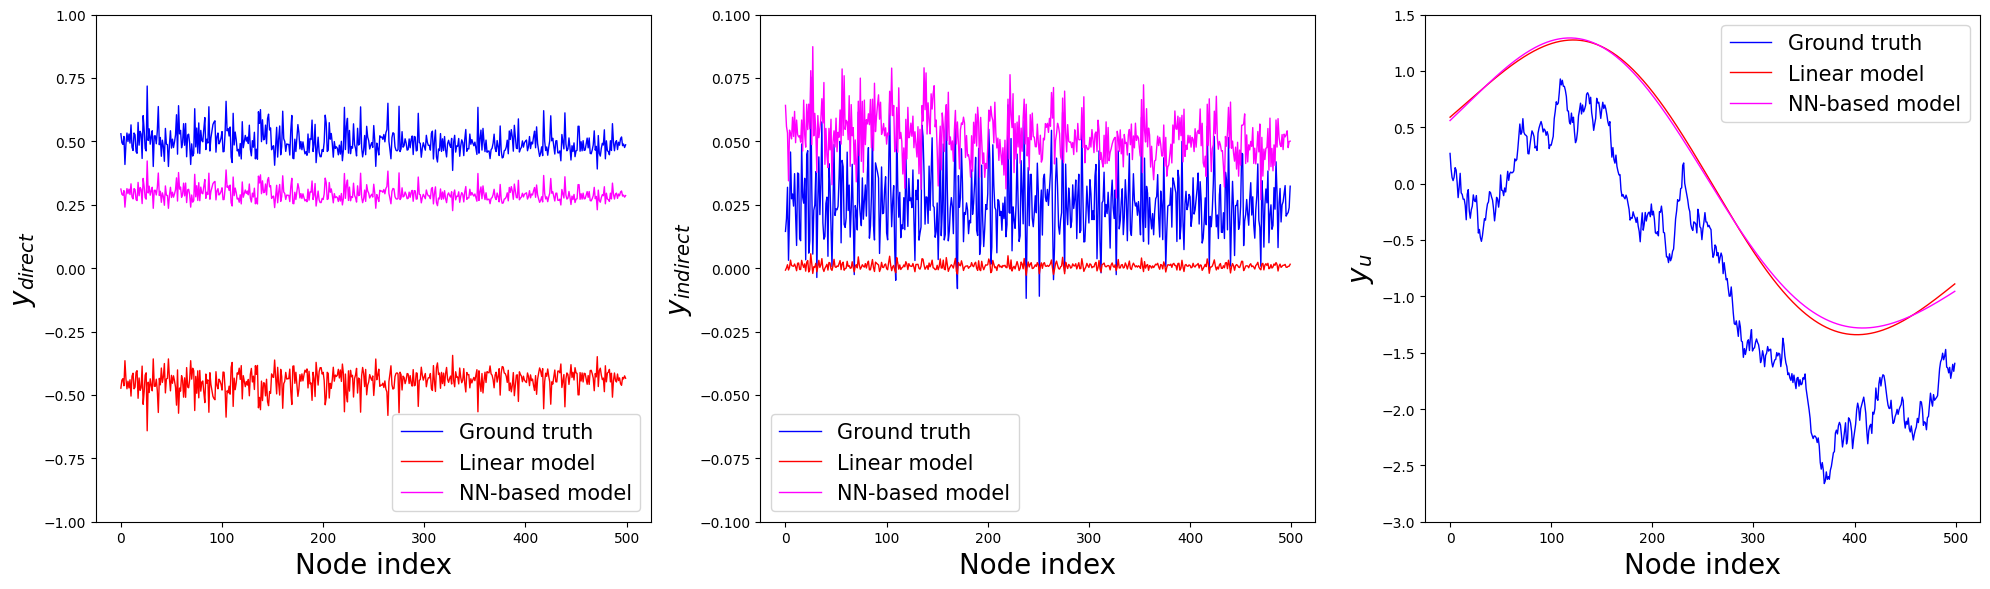

In [14]:
quantities = ['y_t', 'y_t_bar', 'u']
ylabels = ['$y_{direct}$', '$y_{indirect}$', '$y_u$']
yrange = [[-1,1],[-0.1,0.1],[-3,1.5]]
fig, axs = plt.subplots(1,3,figsize=(20,6))
graph_indices = np.arange(len(res['y_t_true']))
for i in range(len(quantities)):
    axs[i].plot(graph_indices, res[f"{quantities[i]}_true"], color='blue', label='Ground truth', lw=1)
    axs[i].plot(graph_indices, res["linear_with_U"][f"{quantities[i]}_pred"], color='red', label='Linear model', lw=1)
    axs[i].plot(graph_indices, res["nonlinear_with_U"][f"{quantities[i]}_pred"], color='magenta', label='NN-based model', lw=1)
    axs[i].set_ylim(yrange[i])
    axs[i].set_xlabel("Node index", fontsize=20)
    axs[i].set_ylabel(ylabels[i], fontsize=20)
    axs[i].legend(prop={'size':15})
plt.tight_layout()
plt.savefig('./Visualization_synthetic.pdf', dpi=300)

# Model 5: GCN model without U (f: GCN, g: MLP)

train_dataset, val_dataset, test_dataset = train_val_test_split(
    t=[T], x=X, s=s, y=Y, train_size=0.6, val_size=0.2, test_size=0.2, 
    shuffle=True, random_state=2020, graph_input=True
)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

num_iterations = 5
de_error_0, de_error_1, ie_error_0, ie_error_1, te_error = [], [], [], [], []

for _ in tqdm(range(num_iterations), position=0, leave=True):
    model = NonlinearSCI(
        num_interventions=1, 
        window_size=neighborhood_size*2+1, 
        confounder_dim=X.shape[1], 
        f_network_type="gcn", 
        g_network_type="mlp", 
        g_hidden_dims=[64,32]
    )
    
    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = "sgd"
    optim_params = {
        'lr': 1e-3, 
        'momentum': 0.99
    }
    epochs, patience = 1000, 50
    trainer = Trainer(
        model=model, 
        data_generators=dataloaders, 
        optim=optim, 
        optim_params=optim_params, 
        device=device,
        epochs=epochs,
        patience=patience
    )
    trainer.train()

    # Evaluation
    y_pred_00 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=False)
    y_pred_01 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=True)
    y_pred_10 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=False)
    y_pred_11 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=True)
    de_0_pred, de_1_pred = np.mean(y_pred_10 - y_pred_00), np.mean(y_pred_11 - y_pred_01)
    ie_0_pred, ie_1_pred = np.mean(y_pred_01 - y_pred_00), np.mean(y_pred_11 - y_pred_10)
    te_pred = np.mean(y_pred_11 - y_pred_00)
    de_error_0.append(np.abs(de_0_pred - de_0))
    de_error_1.append(np.abs(de_1_pred - de_1))
    ie_error_0.append(np.abs(ie_0_pred - ie_0))
    ie_error_1.append(np.abs(ie_1_pred - ie_1))
    te_error.append(np.abs(te_pred - te))

print("Error on prediction of average local and interference effects:")
print("--------------------------------------------------------------")
print(f"Average direct effect (T_bar = 0) = {np.mean(de_error_0):.5f} +/- {np.std(de_error_0):.5f}")
print(f"Average direct effect (T_bar = 1) = {np.mean(de_error_1):.5f} +/- {np.std(de_error_1):.5f}")
print(f"Average indirect effect (T = 0) = {np.mean(ie_error_0):.5f} +/- {np.std(ie_error_0):.5f}")
print(f"Average indirect effect (T = 1) = {np.mean(ie_error_1):.5f} +/- {np.std(ie_error_1):.5f}")
print(f"Average total effect = {np.mean(te_error):.5f} +/- {np.std(te_error):.5f}")

# Model 6: GCN model with U (f: GCN, g: MLP)

num_iterations = 5
de_error_0, de_error_1, ie_error_0, ie_error_1, te_error = [], [], [], [], []

for _ in tqdm(range(num_iterations), position=0, leave=True):
    model = NonlinearSCI(
        num_interventions=1, 
        window_size=neighborhood_size*2+1, 
        confounder_dim=X.shape[1], 
        f_network_type="gcn", 
        g_network_type="mlp", 
        g_hidden_dims=[64,32], 
        unobserved_confounder=True, 
        kernel_param_vals=[1.,0.5,0.1]
    )
    
    # Training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = "adam"
    optim_params = {
        'lr': 1e-3, 
        # 'momentum': 0.99
    }
    epochs, patience = 1000, 50
    trainer = Trainer(
        model=model, 
        data_generators=dataloaders, 
        optim=optim, 
        optim_params=optim_params, 
        device=device,
        epochs=epochs,
        patience=patience
    )
    trainer.train()

    # Evaluation
    y_pred_00 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=False)
    y_pred_01 = trainer.predict(neighborhood_size*2+1, direct=False, indirect=True)
    y_pred_10 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=False)
    y_pred_11 = trainer.predict(neighborhood_size*2+1, direct=True, indirect=True)
    de_0_pred, de_1_pred = np.mean(y_pred_10 - y_pred_00), np.mean(y_pred_11 - y_pred_01)
    ie_0_pred, ie_1_pred = np.mean(y_pred_01 - y_pred_00), np.mean(y_pred_11 - y_pred_10)
    te_pred = np.mean(y_pred_11 - y_pred_00)
    de_error_0.append(np.abs(de_0_pred - de_0))
    de_error_1.append(np.abs(de_1_pred - de_1))
    ie_error_0.append(np.abs(ie_0_pred - ie_0))
    ie_error_1.append(np.abs(ie_1_pred - ie_1))
    te_error.append(np.abs(te_pred - te))

print("Error on prediction of average local and interference effects:")
print("--------------------------------------------------------------")
print(f"Average direct effect (T_bar = 0) = {np.mean(de_error_0):.5f} +/- {np.std(de_error_0):.5f}")
print(f"Average direct effect (T_bar = 1) = {np.mean(de_error_1):.5f} +/- {np.std(de_error_1):.5f}")
print(f"Average indirect effect (T = 0) = {np.mean(ie_error_0):.5f} +/- {np.std(ie_error_0):.5f}")
print(f"Average indirect effect (T = 1) = {np.mean(ie_error_1):.5f} +/- {np.std(ie_error_1):.5f}")
print(f"Average total effect = {np.mean(te_error):.5f} +/- {np.std(te_error):.5f}")